# Buck Converter design sheet
## About:
This is a project sheet for an ideal buck converter operating in continuous conduction mode.
Written by Eduardo Eller Behr for his own use

# Setup

In [1]:
%matplotlib inline
# from classes import *  # my customs classes
from sympy.physics.units import ohms, volts, amperes, watts, Hz, convert_to, henry, farad, second
# from input_parameters import *
# import pandas as pd
from matplotlib import pyplot as plt
from numpy import sqrt, pi, sin, cos
from simulationbuck import SimulationBuck
from background import sympy_strip, OperationModePlot, rms
from scipy import signal
import numpy as np
import sympy as sp

# Input 
## Project Parameters (necessary)
# <font color='red'> TODO: estimate frequency dependent power loss! (add plots 'n shit)</font>

In [2]:
Vin = 311#*volts    # input voltage
Vout = 100#*volts    # output voltage
Pout = 1000#*watts  # output power
fs = 20e3#*Hz    # switching frequency
dIL_max = 1#*amperes # maximum Inductor current ripple
Vd = 0  # TODO diode voltage drop
#dVout_max = 100*volt # maximum Capacitor voltage ripple

## Secondary parameters (not necessary beforehand)

In [3]:
R_inductor = 0.01# * ohms  # Resistance of the inductor's coil. Only needed for analysis
LC_cutoff = fs/10
Eon = 10e-3  # MosFET switching on energy loss per switching period
Eoff = Eon  # MosFET switching off energy loss per switching period
Qr = 1e-6  # Diode reverse recovery charge

In [4]:
# C_out = 1.5e-6 * farad  # Output capacitance. Needed for the analysis of filter

# Preliminar calculations

In [5]:
a = Vout/Vin  # static gain
D = Vout/Vin  # duty cycle for buck converter on continuous conduction mode
Rload = convert_to(Vout**2/Pout,ohms)  # equivalent output resistor for project
convert_to(Rload,ohms).evalf(3)
I_out = Vout/(Rload+R_inductor)  # average output current
IL_avg = convert_to(I_out,amperes).evalf()  # in the case of the Buck, the average inductor current is the same as the output
IL_max = convert_to(IL_avg + dIL_max/2,amperes).evalf()
IL_min = convert_to(IL_avg - dIL_max/2,amperes).evalf()
print(f'{D=}, {Rload.evalf()=}')
print(f'{IL_avg=}, {IL_max=}, {IL_min=}')

D=0.3215434083601286, Rload.evalf()=10.0000000000000
IL_avg=9.99000999000999, IL_max=10.4900099900100, IL_min=9.49000999000999


## Inductor
$ 
L \cdot {{\Delta I_L}\over{\Delta t}} = V_{in} - V_{out} \rightarrow 
L = {{(V_{in}-V_{out}) D}\over{f_s \Delta I_L}}
, where \space \Delta t = {{D} \over {f_s}}
$

In [6]:
L = (Vin-Vout)*D/(fs*dIL_max)
L=convert_to(L, henry)
print('Inductance L: '); display(L)
print(f'Recommended C_out: ');
C_out = convert_to(1/((2*pi*LC_cutoff)**2*L).evalf(3),farad)
display(C_out); print('Choose the nearest commercial value.')

Inductance L: 


0.00339228295819936

Recommended C_out: 


1.87e-6

Choose the nearest commercial value.


# Analysis
## Static gain $\big({V_{out}\over V_{in}}\big)$ while including inductor losses
${{V_{out}}\over{V_{in}}} = D \cdot \frac{R}{R+R_inductor}$

'Real gain with resistive inductor losses: ~32.122%'

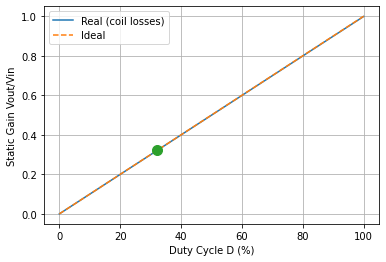

In [7]:
D_plt = np.linspace(0, 1, 101)
R_inductor_plt = sympy_strip(R_inductor)  # gets numerical value
Rload_plt = sympy_strip(Rload)
a_plt = D_plt*Rload_plt/(Rload_plt+R_inductor_plt)
a_plt[a_plt==sp.nan] = 0  # removes nan values
plt.plot(D_plt*100, a_plt); plt.plot(D_plt*100, D_plt,'--'); plt.legend(['Real (coil losses)', 'Ideal'])
plt.xlabel('Duty Cycle D (%)'); plt.ylabel('Static Gain Vout/Vin'); plt.grid(True)
a_real = D*Rload/(Rload+R_inductor)
plt.plot(100*D,a_real,'.',markersize=20)
display('Real gain with resistive inductor losses: ~{:.3%}'.format(a_real))

## Efficiency η while including inductor losses

$η=\big(1+{{R_{inductor}}\over{R_{load}}}\big)^{-1}=\big(1+ɣ\big)^{-1}$

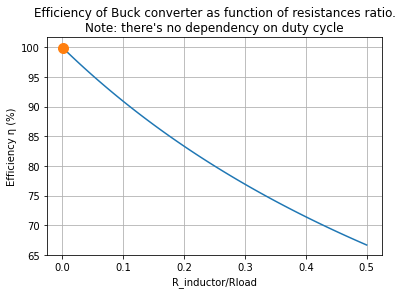

In [8]:
# η = 1/(1+R_inductor_plt/(Rload_plt*(1-D_plt)**2))  # boost
ɣ = np.linspace(0,.5,101)  # ɣ = R_inductor/Rload
η = 1/(1+ɣ)
plt.plot(ɣ,η*100); plt.plot(R_inductor/Rload,100/(1+R_inductor/Rload),'.',markersize=20)
plt.xlabel('R_inductor/Rload'); plt.ylabel('Efficiency η (%)'); plt.grid(True)
plt.title("Efficiency of Buck converter as function of resistances ratio.\nNote: there's no dependency on duty cycle");

Maximum load: 


10.0000000000000

1000

Max. efficiency (100% load): 99.90%


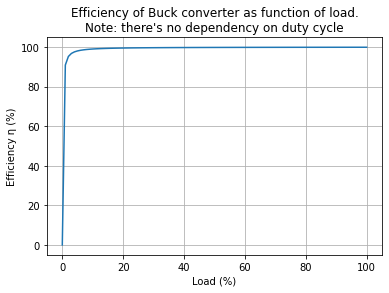

In [9]:
# Efficiency x Rload
print('Maximum load: '); display(Rload.evalf(),Pout)

Rl = sympy_strip(Rload)
Rload_plt = np.linspace(1e-9,Rl,101)  # ɣ = R_inductor/Rload
percent = np.linspace(0,100, len(Rload_plt))
η = 1/(1+R_inductor_plt/Rload_plt)
print('Max. efficiency (100% load): {:.2%}'.format(η[-1]))
plt.plot(percent,η*100); 

plt.xlabel('Load (%)'); plt.ylabel('Efficiency η (%)'); plt.grid(True)
plt.title("Efficiency of Buck converter as function of load.\nNote: there's no dependency on duty cycle");

# <font color='green'> Modos de operação </font>
https://en.wikipedia.org/wiki/Buck_converter#/media/File:Buck_continuous_discontinuous.svg

Io=10.0
L=0.0033922829581993566
Io=10.0
fs=20000.0
Vi=311.0
Inorm=2.181532449002802


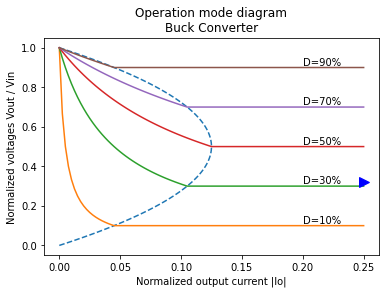

In [10]:
# opmode = OperationModePlot(Vo=48,Vi=480, Io=15,L=0.00108,fs=fs)
opmode = OperationModePlot(Vo=Vout,Vi=Vin, Io=Pout/Vout, L=L,fs=fs)
opmode.draw()
# FIXME

## Output filter 

In [11]:
C_plt = sympy_strip(C_out); L_plt = sympy_strip(L); Rload_plt = sympy_strip(Rload)
f_res = 1/(sqrt(L_plt*C_plt)*2*pi)#*Hz;
print('Resonant frequency: {:.5}'.format(f_res))
ζ=(L_plt/C_plt)**0.5/(2*Rload_plt)
print(f'Damping factor: ζ={round(ζ,2)}')


Resonant frequency: 2000.0
Damping factor: ζ=2.13


## Small signals transfer function (average model):
# <font color=red > USE control instead of scipy </font>
### $\frac{V_{out}}{\tilde{d}} = \frac{V_{in}}{s^2LC+s\big[\frac{L}{R_{load}}+CR_{inductor}\big]+\big[1+\frac{R_{inductor}}{R_{load}}\big]}$

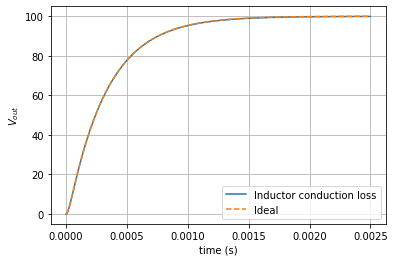

In [12]:
lti = signal.lti([sympy_strip(D*Vin)], [*sympy_strip(L*C_out, convert_to(L/Rload+C_out*R_inductor,second), 1+R_inductor/Rload)])
lti2 = signal.lti([sympy_strip(D*Vin)], [sympy_strip(L*C_out), sympy_strip(L/Rload), 1])
time = np.linspace(0,sympy_strip(50*1/fs),1000)
plt.plot(*lti.step(X0=0,T=time), *lti2.step(T=time),'--'); plt.legend(['Inductor conduction loss', 'Ideal'])
plt.xlabel('time (s)'); plt.ylabel('$V_{out}$'); plt.grid(True)

(6.309573444801933, 158489.3192461114)

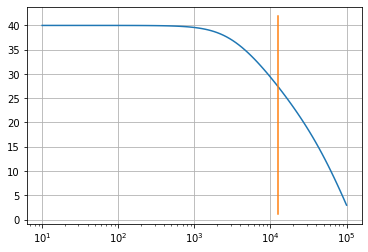

In [13]:
w, mag, phase = lti.bode(w=np.logspace(1,5,100))
plt.semilogx(w,mag); plt.grid(True)
ax = plt.gca()
plt.semilogx(2*[sympy_strip(f_res)*6.28],ax.get_ylim())

# plt.axis([1e2,1e4,30,33.5])

display(ax.get_xlim())

In [14]:
lti

TransferFunctionContinuous(
array([1.57907129e+10]),
array([1.00000000e+00, 5.35695143e+04, 1.58065037e+08]),
dt: None
)

# Simulation
The SimulationBuck class essentially solves the following ODE with varying $V_{in}$ according to duty cycle.
# $
\begin{equation}
\frac{di_L}{dt}
=
\frac{V_{in} - v_{out}- R_{inductor}\cdot i_L}{L}
\end{equation}
$

# $
\frac{dv_{out}}{dt} 
=
\frac{i_L - \frac{v_{out}}{ R_{load}}}{C}
$
The ODE solver is the implicit Midpoint method below, valid for **time-invariant** $f(t,y)$.

$
\frac{dy}{dt} = f(t,y) \rightarrow
y_{n} = y_{n-1} + f\big(\frac{y_{n-1}}{2} + \frac{y{n}}{2}\big)
$

simu = BuckSimulation(Vin, Vout, Pout, fs,)

self.fres=1999.9585784930875
self.L=0.0033922829581993566
self.C=1.8668361008167267e-06
Time step dt= 2.5001250062503124e-07 seconds
Resonant frequency: 1999.9585784930875 Hz
Samping frequency: 3999800.0Hz


,Parameter,Value
,Resonant frequency,1.999959e+03
,Samping frequency,3.999800e+06


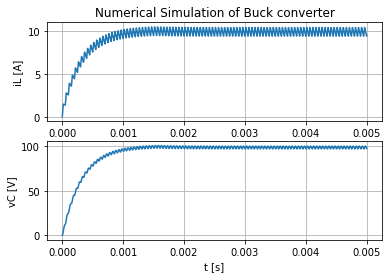

In [15]:
simulation = SimulationBuck(Vin, 
                            D, 
                            L, 
                            Rload, 
                            fs, 
                            R_inductor, 
                            C_out=C_out,
                            RDSon=20e-3,
                            Vdiode=0.7,
                            Eon=Eon,
                            Eoff=Eoff,
                            Qr=Qr)
simulation.compute()
ax1, ax2 = simulation.plot_states()

# ax1.set_xlim([0,.001])
# ax1.set_ylim([-.01,.2])
plt.show()

In [16]:
length = len(simulation.iL)  # length of simulated data
half = int(length/2+1)  # half way through the simulated data

print('iL average: ', simulation.iL[half:].mean())
print('Vout average: ', simulation.vC[half:].mean())

iL average:  9.89011938411809
Vout average:  98.9011256586787


i_diode average:  6.727118188841063
i_FET RMS: 5.592793159817486
Mean Conduction Power loss:  5.647628289700247 W
Mean Switching Power loss:  406.2403130313031 W


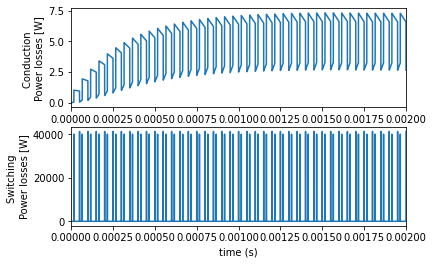

In [17]:
ax3, ax4 = simulation.plot_power()
ax3.set_xlim([0,.002]);

print('i_diode average: ', simulation.id[half:].mean())
print('i_FET RMS:', rms(simulation.ifet[half:]))
print('Mean Conduction Power loss: ', np.mean(simulation.Pc[half:]), 'W')
print('Mean Switching Power loss: ', np.mean(simulation.Ps[half:]), 'W')


In [18]:
print('MosFET RMS Current (i_FET):', rms(simulation.ifet[half:]))
print('Mean Switching Power losses (Ps):', simulation.Ps.mean())

MosFET RMS Current (i_FET): 5.592793159817486
Mean Switching Power losses (Ps): 406.199689


# References
[1] https://en.wikipedia.org/wiki/Buck_converter

[2] Erickson, Robert W. Fundamentals of Power Electronics, $2^{nd}$ edition. 2001

In [19]:
fs

20000.0